In [1]:
# !pip install emoji
# !pip install cufflinks --upgrade
# !pip install wordcloud
# !pip install scattertext
# !pip install spacy
import pandas as pd
import numpy as np
import string
import re
from bs4 import BeautifulSoup
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
from utils import emo
import emoji
import string
from wordcloud import WordCloud
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import scattertext as st
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
g_emot = ['data/goemotions_2.csv','data/goemotions_3.csv']
df = pd.read_csv('data/goemotions_1.csv')
for g in g_emot:
    tdf = pd.read_csv(g)
    df = df.append(tdf, ignore_index=True)

In [3]:
del df['id']
del df['author']
del df['subreddit']
del df['link_id']
del df['parent_id']
del df['created_utc']
del df['rater_id']
del df['example_very_unclear']

In [4]:
PUNCT_TO_REMOVE = string.punctuation
UNICODE_EMO = emo.UNICODE_EMOJI
EMOTICONS = emo.EMOTICONS_EMO

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
def remove_html(text):
    return BeautifulSoup(text, "lxml").text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def clean_tweets(x):
    x = re.sub('@\w*','',x)
    x = re.sub('\.*\.',' ',x)
    x = re.sub(' +',' ',x)
    return x

#  Converting Emoticons Start

str_emo = str(EMOTICONS)[1:-1]
str_emo = str_emo.replace("\\","\\\\")
str_emo = str_emo.replace('(','\(')
str_emo = str_emo.replace(')','\)')
str_emo = str_emo.replace('[','\[')
str_emo = str_emo.replace(']','\]')
str_emo = str_emo.replace('{','\{')
str_emo = str_emo.replace('}','\}')
str_emo = str_emo.replace('.','\.')
str_emo = str_emo.replace('$','\$')
str_emo = str_emo.replace('*','\*')
ttr_emo = '{'+str_emo+'}'
mod_emo = eval(ttr_emo)

def convert_emoticons(text):
    for e,m in zip(EMOTICONS,mod_emo):
        if e in text:
            text = re.sub(m, "_".join(EMOTICONS[e].replace(",","").split()), text)
    return text

# Converting Emoticons End


def convert_emojis(text):
    return emoji.demojize(text)



def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"won’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase
pos_emo = ['admiration' , 'amusement' , 'approval' , 'caring' , 'curiosity' , 'desire' , 'excitement' , 'gratitude' , 'joy' , 'love' , 'optimism' , 'pride' , 'realization' ,'relief' ,'surprise' ,'neutral']
neg_emo = ['anger' , 'annoyance' , 'confusion' , 'disappointment' , 'disgust' , 'embarrassment' , 'fear' , 'grief' , 'nervousness' , 'remorse' , 'sadness' , '']

In [5]:
df['text'] = df['text'].apply(lambda x: convert_emojis(x)) # converting emojis to text (Time consuming step !!!)
df['text'] = df['text'].apply(lambda x: convert_emoticons(x)) # converting emoticons to text
df['text'] = df['text'].apply(lambda x: x.lower())   # converting data to lowecase
df['text'] = df['text'].apply(lambda x: decontracted(x)) 
df['text'] = df['text'].apply(lambda x: remove_urls(x))  
df["text"] = df["text"].apply(lambda x: remove_punctuation(x)) # removing unwanted characters

In [6]:
dic= {}
k=1
for d in df.columns[1:]:
    if d in pos_emo:
        dic[k] = 'p'
    else:
        dic[k] = 'n'
    k+=1
df['positive'] = [0]*len(df)
df['negative'] = [0]*len(df)
dummy = df.values
for row in dummy:
    try:
        idx = list(row).index(1)
    except:
        idx = -1
    if idx !=-1:
        if dic[idx] == 'p':
            row[-1] = 1
        else:
            row[-2] = 1
df = pd.DataFrame(dummy,columns=df.columns)
df = df.filter(['text','positive','negative'])
df = df[df['positive'] != df['negative']]

# Visual Data analysis

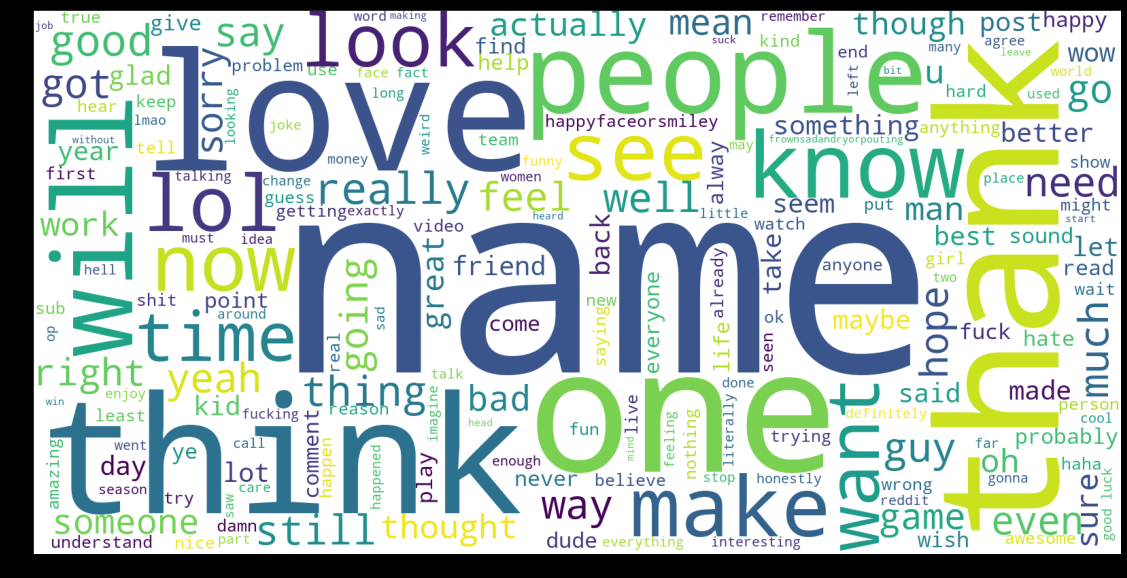

In [13]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(df['text'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.savefig('books_read1.png')

In [8]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
tup = []
for word, freq in common_words:
    tup.append((word, freq))
    
    
kf = pd.DataFrame(tup,columns=['word', 'freaquency'])
kf.to_csv('output/uni-gram_with_stop_words.csv',index=False)

df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

In [9]:
def get_top_n_word(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_word(df['text'], 20)
tup = []
for word, freq in common_words:
    tup.append((word, freq))
    
    
kf = pd.DataFrame(tup,columns=['word', 'freaquency'])
kf.to_csv('output/uni-gram_without_stop_words.csv',index=False)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

In [10]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_word(df['text'], 20)
tup = []
for word, freq in common_words:
    tup.append((word, freq))
    
    
kf = pd.DataFrame(tup,columns=['word', 'freaquency'])
kf.to_csv('output/bi-gram_with_stop_words.csv',index=False)

df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')


In [11]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
tup = []
for word, freq in common_words:
    tup.append((word, freq))
kf = pd.DataFrame(tup,columns=['word', 'freaquency'])
kf.to_csv('output/uni-gram_with_stop_words.csv',index=False)


df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

<BarContainer object of 2 artists>

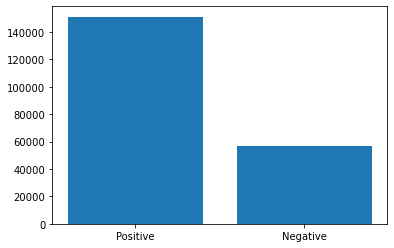

In [12]:
plt.figure(figsize=(6, 4))
plt.bar(['Positive','Negative'],list(df.positive.value_counts()))